In [1]:
import numpy as np
import astropy
from astropy import units as u
from astropy.time import Time, TimeMJD
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, FK5
from astropy.coordinates import get_sun
from scipy.special import jn
from astropy.coordinates.angles import Angle
have_moon=False
%pylab inline
#maybe dangerous, but it irks me
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

import sys,os
sys.path=["py","../py"]+sys.path
from CrimeReader import CrimeReader
import healpy as hp

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
astropy.__version__

u'1.0.5'

In [3]:
whitehouse=EarthLocation(lat=40.87792*u.deg, lon=-72.85852*u.deg, height=0*u.m)

In [4]:
utcoffset = -4*u.hour
time = Time('2016-08-01 00:00:00') - utcoffset


In [5]:
mjd=time.mjd
Time(mjd, format='mjd')


<Time object: scale='utc' format='mjd' value=57601.1666667>

In [6]:
aa=AltAz(obstime=time,location=whitehouse,alt=90*u.deg, az=180*u.deg)
aa2=AltAz(obstime=time,location=whitehouse,alt=30*u.deg, az=110*u.deg)

In [7]:
# get angle on alt-az
skyc=aa.transform_to(FK5)
xc=SkyCoord("19:59:28 +40:44",unit=(u.hourangle, u.deg))
sep1=skyc.separation(xc)
print (sep1/u.deg)

2.02929031108


In [8]:
xcaa=xc.transform_to(aa)
xc.separation(aa),xcaa.separation(aa), xcaa.alt

(<Angle 2.029279192217042 deg>,
 <Angle 2.0292791922142297 deg>,
 <Latitude 87.97072080778295 deg>)

In [9]:
dt=np.linspace(0,2.,1000)
times_mjd=mjd+dt
times=Time(times_mjd, format='mjd')
aa=AltAz(obstime=times,location=whitehouse,alt=90*u.deg, az=0*u.deg)
sunpos=get_sun(times)
sunsep=sunpos.separation(aa)
sunalt=sunpos.transform_to(aa).alt
sunsep[where(sunalt<0)]=NaN

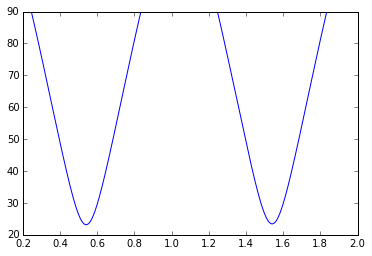

In [10]:
plot (dt,sunsep)

In [11]:
objs=[("CassA","23:23:26 +58:48"), ("CygA", "19:59:28 +40:44"),("Crab","5:34:32 +22:00:52"),("M31","0:42:43 +41:16:9"),]
objs=map(lambda x:(x[0],SkyCoord(x[1],unit=(u.hourangle, u.deg))),objs)
fluxes=[("sun",4e4,1e6),("moon",8,800), ("CassA",2e4,5e3),("CygA",1.5e4, 2e3),("Crab",2e3,1e3),("M31",5e2,2e2)]
fluxdic100,fluxdic1000={},{}
for n,l,h in fluxes:
    fluxdic100[n]=l
    fluxdic1000[n]=h
    

      

In [12]:
seps=[("sun",sunsep)]
if have_moon:
    seps.append(("moon",moonsep))
for name,cor in objs:
    csep=aa.separation(cor)
    calt=cor.transform_to(aa).alt
    csep[where(calt<0)]=NaN
    seps.append((name,csep))
    
                      

In [13]:
lambdamin=0.375
def airy(theta):
    ## at 800Mhz, lambda=0.375
    x=pi*4./lambdamin*theta.radian
    #print(x)
    return (2*jn(1,x))**2/x**2
def airy2(theta):
    ## at 800Mhz, lambda=0.375
    x=pi*4./lambdamin*theta.radian
    #print(x)
    return (sin(x)**2)/x**2

def gbeam(theta):
    sig=lambdamin/(4.*sqrt(8*log(2.)))
    return exp(-theta.radian**2/(2*sig**2))



[]

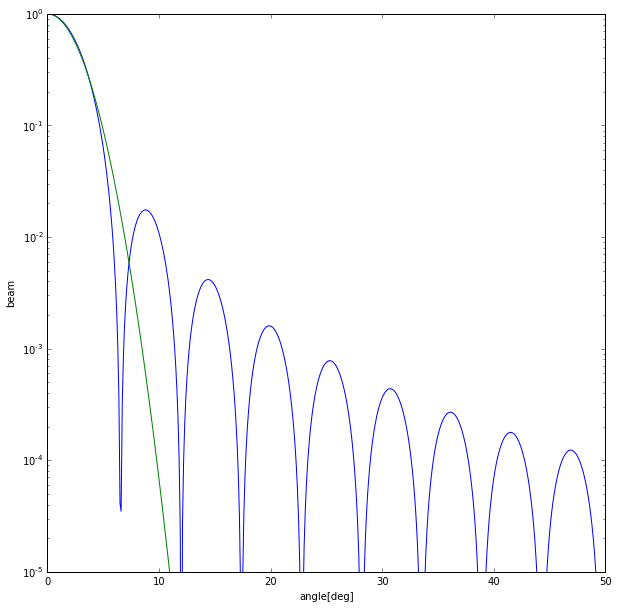

In [14]:
figure(figsize=(10,10))
theta=arange(0.1,50,0.1)
beam=airy(Angle(theta*u.deg))
beam2=gbeam(Angle(theta*u.deg))
plot(theta,beam)
plot(theta,beam2)
pylab.ylim(1e-5,1)
#pylab.xlim(0,80)
xlabel("angle[deg]")
ylabel("beam")
pylab.semilogy()


In [15]:
freq=800
sig=zeros(len(times))
lam=3e2/freq
Jy2K=1e-26/((2*pi*(lambdamin/(4.*sqrt(8*log(2.))))**2)*(2*1.38e-23))*lam*lam
for name,s in seps[:]:
    l,h=fluxdic100[name],fluxdic1000[name]
    flux=l*(h/l)**((freq-100)/900.)
    air=airy(s)
    air[where(isnan(air))]=0.0
    sig+=flux*air*Jy2K
    print (name,flux)


('sun', 489042.5696195377)
('CassA', 6803.950000871884)
('CygA', 3129.594387032238)
('Crab', 1166.5290395761165)
('M31', 245.16648961063822)


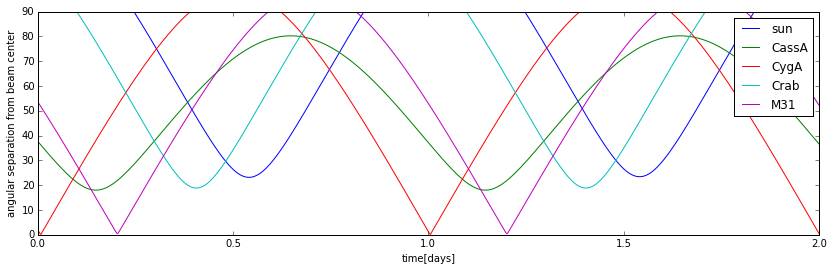

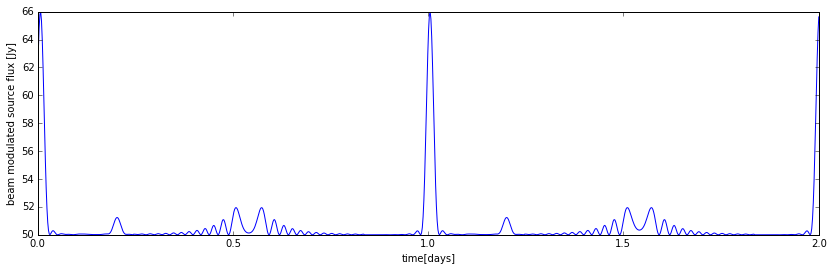

In [16]:
figure(figsize=(14,4))
for name,s in seps[:]:
    plot(dt,s,label=name)
xlabel("time[days]")
ylabel("angular separation from beam center")
legend()
figure(figsize=(14,4))
plot(dt,sig+50)
#semilogy()
xlabel("time[days]")
ylabel("beam modulated source flux [Jy]")


In [17]:
Snoisel2=(2*pi*(lambdamin/(4.*sqrt(8*log(2.))))**2)*(2*1.38e-23*50)/1e-26
Snoisel2/0.375**2
#Snoise/0.375**2

9772.9015558148876

In [18]:
r=CrimeReader()

Have  200 slices.
z min, max: 0.183671 0.291278


In [19]:
hp.visufunc.gnomview(map = r.cosmo_slice(10), xsize = 240, ysize = 240,
                             coord = None,rot = (0,5,0), reso = 6)

Reading  /home/anze/work/BMX/crime/output/cosmo_010.fits
NSIDE = 512
ORDERING = RING in fits file


/home/anze/local/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [73]:
pr=hp.projector.GnomonicProj(xsize = 240, ysize = 240,rot = (3.,6.,70.), reso = 4)

In [74]:
sl=r.cosmo_slice(12)
vec2pix=lambda x,y,z:hp.vec2pix(512,x,y,z)
mp=pr.projmap(sl,vec2pix)
imshow(mp, origin='lower')

In [57]:
beam=np.array([[airy(Angle(sqrt((np.array(pr.ij2xy(i,j))**2).sum())*u.rad)) for i in range(240)] for j in range(240)])

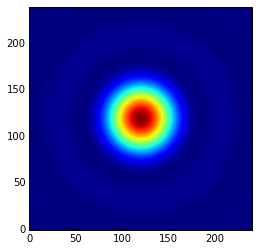

In [42]:
imshow(beam, origin='lower')

In [47]:
(mp*beam).sum()/beam.sum()

0.11316247851909324

In [64]:
skyc.ra.deg

297.18971704383927